<a href="https://colab.research.google.com/github/juliacamposn/trabalho_kdTree/blob/main/trabalho_1_ed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kagglehub requests deepface Pillow tensorflow

In [2]:
import os
from google.colab import files

#precisei pedir o token no site kaggle
if not os.path.exists("/root/.kaggle/kaggle.json"):
    uploaded = files.upload()
    if "kaggle.json" in uploaded:
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("\n Autenticação do Kaggle configurada com sucesso!")
    else:
        print("\n Arquivo 'kaggle.json' não foi enviado. A próxima célula pode falhar.")
else:
    print("\n Autenticação do Kaggle já estava configurada.")


 Autenticação do Kaggle já estava configurada.


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("atulanandjha/lfwpeople")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lfwpeople


In [7]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lfwpeople/pairsDevTrain.txt
/kaggle/input/lfwpeople/lfw-funneled.tgz
/kaggle/input/lfwpeople/pairsDevTest.txt
/kaggle/input/lfwpeople/pairs.txt


In [8]:
#Descompactação do Dataset
import os
import tarfile

archive_path = '/kaggle/input/lfwpeople/lfw-funneled.tgz'
extract_dir = '/content/lfw_dataset_extraido'

if not os.path.exists(archive_path):
    print(f" ERRO: O arquivo de dataset '{archive_path}' não foi encontrado.")
else:
    os.makedirs(extract_dir, exist_ok=True)
    print(f"Descompactando para '{extract_dir}'")
    try:
        with tarfile.open(archive_path, 'r:gz') as tar:
            tar.extractall(path=extract_dir)
        print("✅ Arquivo descompactado com sucesso.")

        lfw_dataset_path = os.path.join(extract_dir, "lfw_funneled")

        if os.path.isdir(lfw_dataset_path):
            print(f"✅ Sucesso! A pasta de imagens está pronta para uso em: {lfw_dataset_path}")
        else:
            print(f"❌ ERRO PÓS-EXTRAÇÃO: A pasta 'lfw_funneled' não foi encontrada em '{extract_dir}'.")

    except Exception as e:
        print(f"❌ Ocorreu um erro durante a descompactação: {e}")

Descompactando para '/content/lfw_dataset_extraido'
✅ Arquivo descompactado com sucesso.
✅ Sucesso! A pasta de imagens está pronta para uso em: /content/lfw_dataset_extraido/lfw_funneled


In [9]:
# Configuração da API e Funções de Ajuda
import requests
from deepface import DeepFace

# ⚠️ AÇÃO NECESSÁRIA:
# 1. Na sua máquina local, inicie a API com: uvicorn api:app --reload
# 2. Em outro terminal, inicie o ngrok com: ./ngrok http 8000
# 3. Cole o URL público gerado pelo ngrok na linha abaixo.
API_BASE_URL = "https://7728-170-150-240-203.ngrok-free.app"


def initialize_kdtree_api():
    """Chama o endpoint para limpar e inicializar a árvore."""
    print("Inicializando a KD-Tree na API...")
    try:
        response = requests.post(f"{API_BASE_URL}/initialize-tree")
        response.raise_for_status()
        print(" KD-Tree inicializada com sucesso.")
        return True
    except requests.exceptions.RequestException as e:
        print(f" FALHA DE CONEXÃO: Verifique se a API e o ngrok estão rodando. Erro: {e}")
        return False

def get_embedding(image_path):
    """Gera um embedding facial para uma imagem."""
    try:
        # Usamos enforce_detection=False pois as imagens LFW já são rostos cortados
        embedding_obj = DeepFace.represent(img_path=image_path, model_name='Facenet', enforce_detection=False)
        return embedding_obj[0]['embedding']

    except Exception:
        return None

def insert_face_api(embedding_vector, person_id_str):
    """Envia um embedding para ser inserido pela API."""
    payload = {"embedding": embedding_vector, "person_id": person_id_str}
    try:
        requests.post(f"{API_BASE_URL}/insert-face", json=payload, timeout=10)
        return True

    except requests.exceptions.RequestException:
        return False

def find_neighbors_api(embedding_vector, num_neighbors=1):
    """Pede para a API encontrar os vizinhos mais próximos."""
    payload = {"query_embedding": embedding_vector, "n_neighbors": num_neighbors}
    try:
        response = requests.post(f"{API_BASE_URL}/find-nearest-neighbors", json=payload, timeout=10)
        return response.json()

    except requests.exceptions.RequestException:
        return None

25-06-11 13:31:28 - Directory /root/.deepface has been created
25-06-11 13:31:28 - Directory /root/.deepface/weights has been created


In [12]:
from google.colab import files
# importando minhas fotos pessoais
uploaded_files = files.upload()

print("\nArquivos enviados com sucesso:")
for filename in uploaded_files.keys():
    print(f"- {filename}")

Saving eu_julia.jpeg to eu_julia.jpeg

Arquivos enviados com sucesso:
- eu_julia.jpeg


Processando a imagem 'eu_julia.jpeg' para encontrar o rosto...
✅ Um rosto foi detectado com sucesso!
O rosto foi recortado e salvo como 'rosto_julia_campos.jpg'


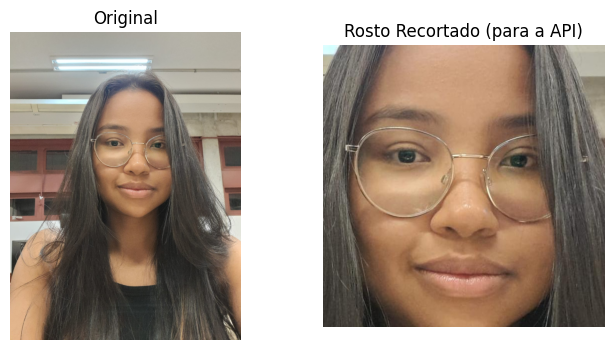

In [28]:
# PRÉ-PROCESSAMENTO DA SELFIE
from deepface import DeepFace
from PIL import Image
import matplotlib.pyplot as plt

selfie_filename = "eu_julia.jpeg"

cropped_face_filename = "rosto_julia_campos.jpg"
face_found = False

print(f"Processando a imagem '{selfie_filename}' para encontrar o rosto...")

try:
    # enforce_detection=True garante que um erro será lançado se nenhum rosto for encontrado.
    face_objs = DeepFace.extract_faces(img_path=selfie_filename, enforce_detection=True)

    if len(face_objs) > 1:
        print(f"❌ ERRO: Múltiplos rostos ({len(face_objs)}) foram detectados na imagem. Por favor, use uma foto com apenas uma pessoa.")

    elif len(face_objs) == 1:
        print("✅ Um rosto foi detectado com sucesso!")

        img = Image.open(selfie_filename)

        facial_area = face_objs[0]['facial_area']
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

        face_img = img.crop((x, y, x + w, y + h))

        # Salvar a nova imagem apenas com o rosto
        face_img.save(cropped_face_filename)
        print(f"O rosto foi recortado e salvo como '{cropped_face_filename}'")
        face_found = True

except ValueError as e:
    print(f"❌ ERRO: Nenhum rosto foi detectado na imagem '{selfie_filename}'. Tente tirar outra foto com melhor iluminação e sem obstruções.")

# Se o rosto foi encontrado, mostrar o antes e o depois
if face_found:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(Image.open(selfie_filename))
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(Image.open(cropped_face_filename))
    axes[1].set_title("Rosto Recortado (para a API)")
    axes[1].axis('off')

    plt.show()

In [30]:
# Popular a KD-Tree
import os
import random

if initialize_kdtree_api():
    print("\nPopulando a base de dados...")

    all_image_paths = [os.path.join(dp, f) for dp, dn, fn in os.walk(lfw_dataset_path) for f in fn if f.lower().endswith(('.png','.jpg','.jpeg'))]
    random.shuffle(all_image_paths)

    known_faces_paths = [
        "rosto_julia_campos.jpg"    # Sua "face"
    ]

    # Prepara a lista final com 1000 faces, incluindo as conhecidas
    faces_to_process = [p for p in known_faces_paths if os.path.exists(p)]
    # Adiciona as outras faces, evitando duplicatas
    for img_path in all_image_paths:
        if len(faces_to_process) >= 1000:
            break
        if img_path not in faces_to_process:
            faces_to_process.append(img_path)

    inserted_count = 0
    inserted_files = [] # Guarda os arquivos que foram inseridos com sucesso

    print(f"Iniciando a inserção de {len(faces_to_process)} faces...")
    for image_path in faces_to_process:
        embedding = get_embedding(image_path)
        if embedding:
            if lfw_dataset_path in image_path:
                person_name = os.path.basename(os.path.dirname(image_path))
                image_name = os.path.splitext(os.path.basename(image_path))[0]
                person_id = f"{person_name}_{image_name}"
            else:
                # Para suas fotos locais, o ID será o nome do arquivo sem a extensão.
                person_id = os.path.splitext(os.path.basename(image_path))[0]

            if insert_face_api(embedding, person_id):
                inserted_count += 1
                inserted_files.append(image_path)
                if inserted_count % 50 == 0:
                    print(f"  ... {inserted_count} faces inseridas.")

    print(f"\n✅Concluído. {inserted_count} faces foram inseridas com sucesso na KD-Tree.")

Inicializando a KD-Tree na API...
 KD-Tree inicializada com sucesso.

Populando a base de dados...
Iniciando a inserção de 1000 faces...
  ... 50 faces inseridas.
  ... 100 faces inseridas.
  ... 150 faces inseridas.
  ... 200 faces inseridas.
  ... 250 faces inseridas.
  ... 300 faces inseridas.
  ... 350 faces inseridas.
  ... 400 faces inseridas.
  ... 450 faces inseridas.
  ... 500 faces inseridas.
  ... 550 faces inseridas.
  ... 600 faces inseridas.
  ... 650 faces inseridas.
  ... 700 faces inseridas.
  ... 750 faces inseridas.
  ... 800 faces inseridas.
  ... 850 faces inseridas.
  ... 900 faces inseridas.
  ... 950 faces inseridas.
  ... 1000 faces inseridas.

✅Concluído. 1000 faces foram inseridas com sucesso na KD-Tree.



 Realizando Teste de Reconhecimento
Consultando com a imagem: _rosto_julia_campos


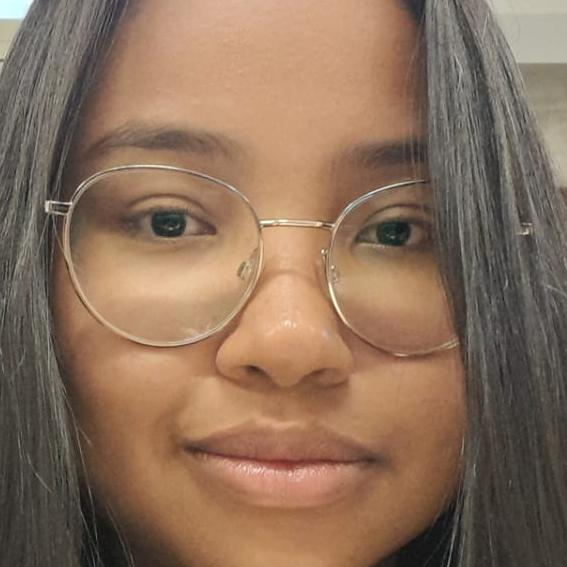


--- Resultados da API ---
ID Encontrado: rosto_julia_campos
Distância: 0.0000

 ATENÇÃO: O vizinho mais próximo foi 'rosto_julia_campos', não a pessoa esperada.

Outros vizinhos próximos:
  2. ID: Tamara_Mowry_Tamara_Mowry_0001, Distância: 9.5090
  3. ID: Mike_Martz_Mike_Martz_0006, Distância: 11.0569


In [31]:
# Teste
from IPython.display import display, Image as IPImage
import random

if 'inserted_files' in locals() and inserted_files:
    print("\n Realizando Teste de Reconhecimento")

    test_image_path = "rosto_julia_campos.jpg"

    # ID esperado para a imagem de teste (lógica simplificada e robusta)
    # Pega o nome do arquivo e remove a extensão (.jpg, .png, etc.)
    expected_id = os.path.splitext(os.path.basename(test_image_path))[0]

    if not os.path.exists(test_image_path):
        print(f" A imagem de teste '{test_image_path}' não foi encontrada.")
    elif test_image_path not in inserted_files:
        print(f" A imagem de teste '{os.path.basename(test_image_path)}' não pôde ser inserida na API. Teste abortado.")
    else:
        # ID esperado para a imagem de teste
        person_name = os.path.basename(os.path.dirname(test_image_path))
        image_name = os.path.splitext(os.path.basename(test_image_path))[0]
        expected_id = f"{person_name}_{image_name}"

        print(f"Consultando com a imagem: {expected_id}")
        display(IPImage(filename=test_image_path, width=150))

        # Gera o embedding e busca na API
        query_embedding = get_embedding(test_image_path)
        if query_embedding:
            neighbors = find_neighbors_api(query_embedding, num_neighbors=3)

            print("\n--- Resultados da API ---")
            if neighbors:
                found_id = neighbors[0]['person_id']
                distance = neighbors[0]['distance']

                print(f"ID Encontrado: {found_id}")
                print(f"Distância: {distance:.4f}")

                if found_id == expected_id:
                    print("\n🎉SUCESSO! O vizinho mais próximo é a pessoa correta.")
                else:
                    print(f"\n ATENÇÃO: O vizinho mais próximo foi '{found_id}', não a pessoa esperada.")

                if len(neighbors) > 1:
                    print("\nOutros vizinhos próximos:")
                    for i, neighbor in enumerate(neighbors[1:]):
                        print(f"  {i+2}. ID: {neighbor['person_id']}, Distância: {neighbor['distance']:.4f}")
            else:
                print(" A API não retornou resultados.")
        else:
            print(" Não foi possível gerar o embedding para a imagem de teste.")
else:
    print("Nenhum arquivo foi inserido. Execute a Célula 5 primeiro.")